### Import 10x scRNA-seq data from exutero-cultured embryos

In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("Matrix")

In [20]:
scdb_init("scrna_db/")

initializing scdb to scrna_db/



In [3]:
matrix.path <- "data/umi.tables/exutero_10x/late_head_fold_embryos/filtered_feature_bc_matrix/matrix.mtx.gz"
barcode.path <- "data/umi.tables/exutero_10x/late_head_fold_embryos/filtered_feature_bc_matrix/barcodes.tsv.gz"
features.path <- "data/umi.tables/exutero_10x/late_head_fold_embryos/filtered_feature_bc_matrix/features.tsv.gz"
mat <- readMM(file = matrix.path)
feature.names = read.delim(features.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
barcode.names = read.delim(barcode.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
colnames(mat) = paste0("HF-",barcode.names$V1)
rownames(mat) = feature.names$V2

In [4]:
md1 = data.frame(cell = paste0("HF-",barcode.names$V1),Experiment = rep("Head_fold",length(barcode.names$V1)))

In [5]:
matrix.path <- "data/umi.tables/exutero_10x/late_streak_embryos/filtered_feature_bc_matrix/matrix.mtx.gz"
barcode.path <- "data/umi.tables/exutero_10x/late_streak_embryos/filtered_feature_bc_matrix/barcodes.tsv.gz"
features.path <- "data/umi.tables/exutero_10x/late_streak_embryos/filtered_feature_bc_matrix/features.tsv.gz"
mat2 <- readMM(file = matrix.path)
feature.names = read.delim(features.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
barcode.names = read.delim(barcode.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
colnames(mat2) = paste0("LS-",barcode.names$V1)
rownames(mat2) = feature.names$V2

In [6]:
md2 = data.frame(cell = paste0("LS-",barcode.names$V1),Experiment = rep("Late_streak",length(barcode.names$V1)))

In [7]:
dim(mat)

[1] 32285  5306

In [8]:
dim(mat2)

[1] 32285 11398

In [9]:
dim(md1)

[1] 5306    2

In [10]:
dim(md2)

[1] 11398     2

In [11]:
mat_all = cbind(mat,mat2)
md_all = rbind(md1,md2)
rownames(md_all) = md_all$cell

In [12]:
mat = scm_new_matrix(mat = mat_all,cell_metadata = md_all,stat_type = "umi")

[1] "mt-Nd1"  "mt-Nd2"  "mt-Co1"  "mt-Co2"  "mt-Atp8" "mt-Atp6" "mt-Co3" 
 [8] "mt-Nd3"  "mt-Nd4l" "mt-Nd4"  "mt-Nd5"  "mt-Nd6"  "mt-Cytb"

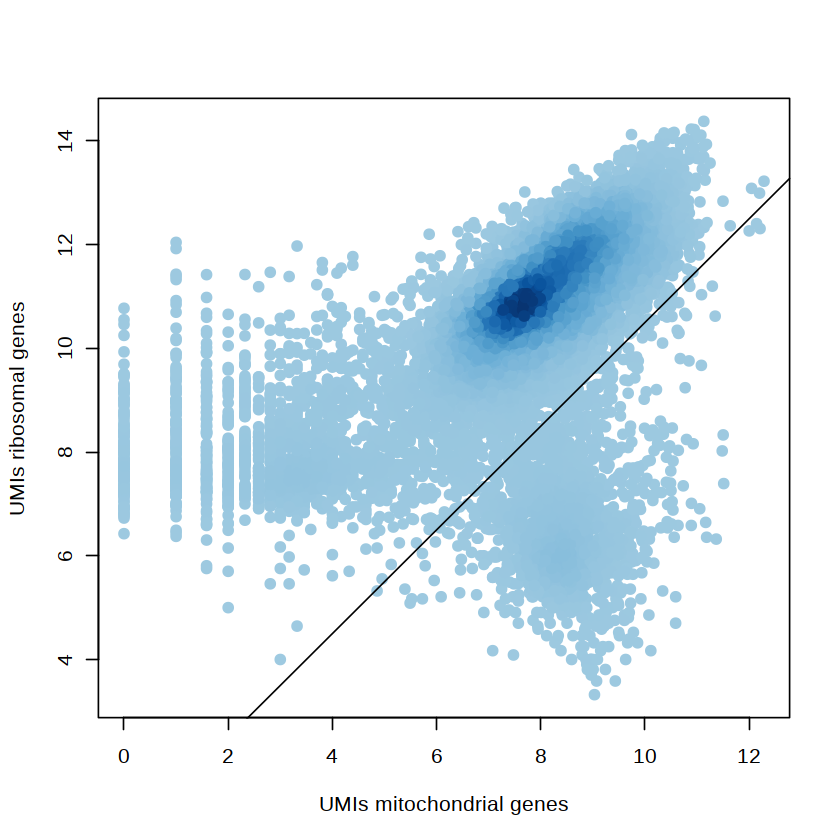

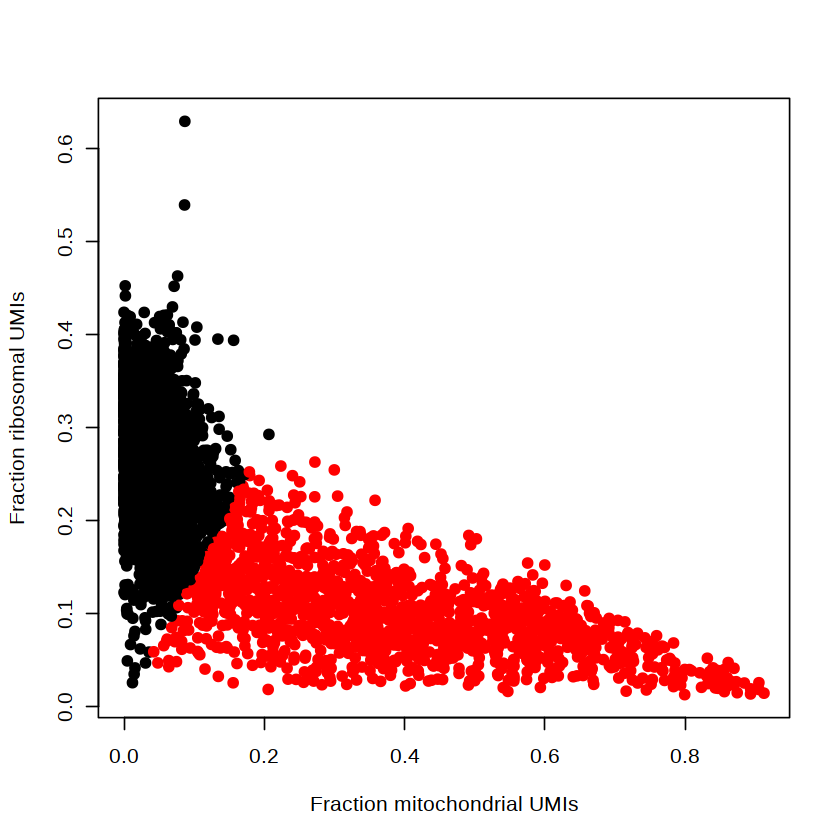

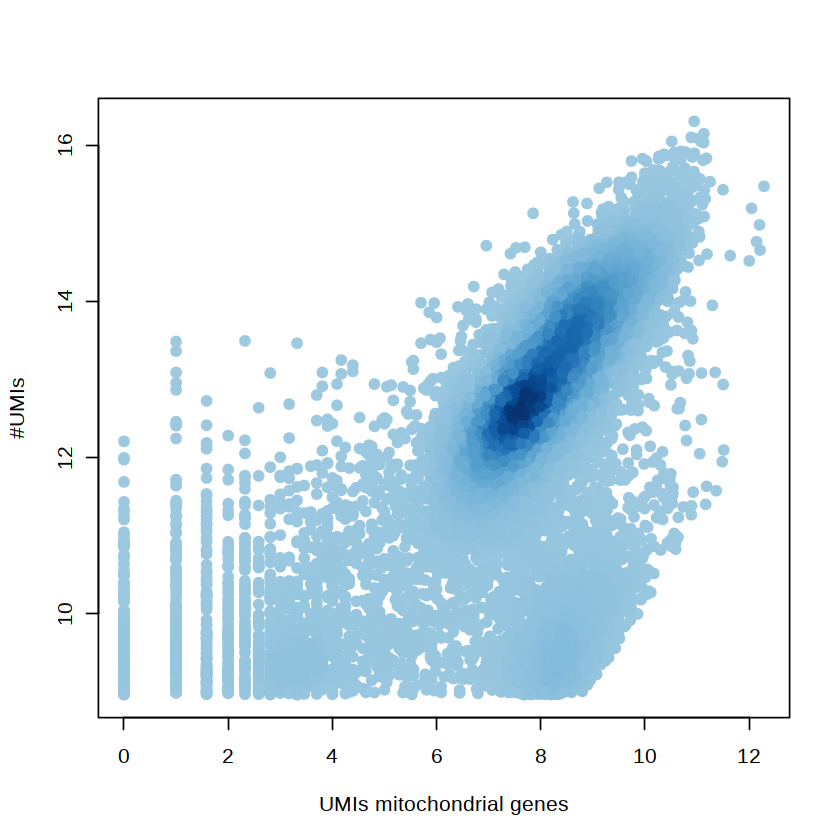

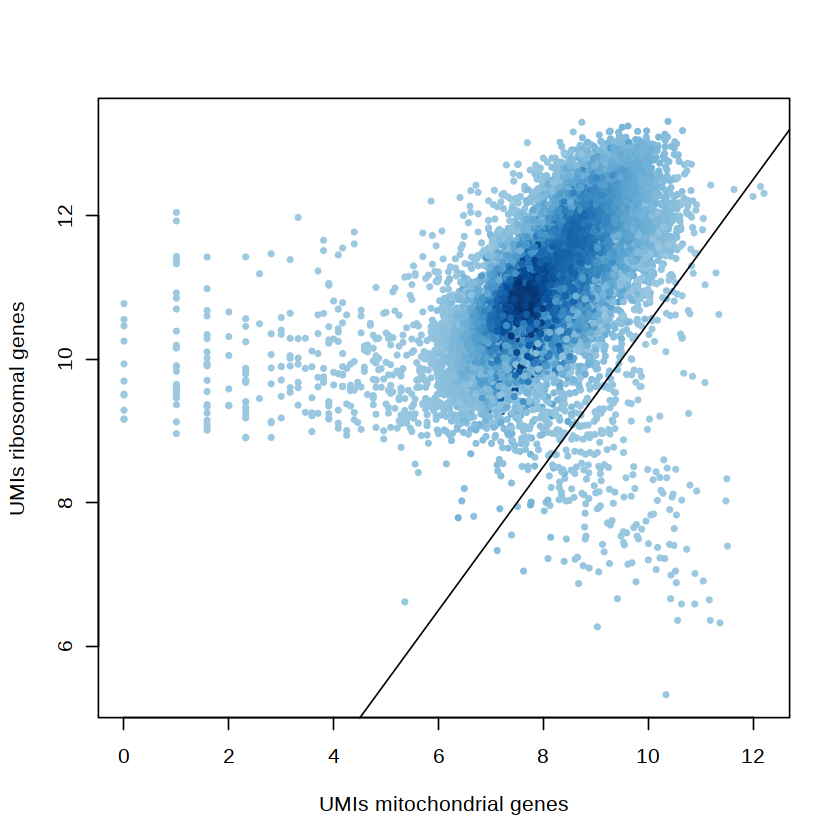

In [13]:
grep("mt-",rownames(mat@mat),v = T)
rps = grep("^Rp[l|s]", rownames(mat@mat),v=T)
#rp_ids = setdiff(unique(gset@gene_set[rps]), ids)
n_umi = colSums(mat@mat)
mt_umi = colSums(mat@mat[grep("mt-",rownames(mat@mat),v = T),])
rp_umi = colSums(mat@mat[rps,])


umi_col = densCols(x = log2(mt_umi + 1),y = log2(rp_umi + 1))
plot(x = log2(mt_umi + 1),y = log2(rp_umi + 1),xlab = "UMIs mitochondrial genes",ylab = "UMIs ribosomal genes",pch = 19,col = umi_col)
abline(a = 0.5,b = 1)
f_mito = log2(rp_umi + 1) < 0.5 + log2(mt_umi + 1)
fr_col = ifelse(f_mito,"red","black")
plot(x = mt_umi/n_umi ,y = rp_umi/n_umi,xlab = "Fraction mitochondrial UMIs",ylab = "Fraction ribosomal UMIs",pch = 19,col  =fr_col)

umi_col = densCols(x = log2(mt_umi + 1),y = log2(n_umi))
plot(x = log2(mt_umi + 1),y = log2(n_umi),xlab = "UMIs mitochondrial genes",ylab = "#UMIs",pch = 19,col = umi_col)

f_middle = n_umi > 2000 & n_umi < 30000
plot(x = log2(mt_umi[f_middle] + 1),y = log2(rp_umi[f_middle] + 1),xlab = "UMIs mitochondrial genes",ylab = "UMIs ribosomal genes",pch = 19,col = umi_col[f_middle],cex = 0.5)
abline(a = 0.5,b = 1)


cells_with_high_mito_content = colnames(mat@mat)[f_mito]

In [14]:
nms = rownames(mat@mat)
bad_genes = c(grep("mt-",rownames(mat@mat),v = T),c("Neat1", "Xist", "Malat1"))

In [15]:
mat = scm_ignore_genes(scmat = mat,ig_genes = bad_genes)
message("The following genes were ignored")
print(bad_genes)

The following genes were ignored



 [1] "mt-Nd1"  "mt-Nd2"  "mt-Co1"  "mt-Co2"  "mt-Atp8" "mt-Atp6" "mt-Co3" 
 [8] "mt-Nd3"  "mt-Nd4l" "mt-Nd4"  "mt-Nd5"  "mt-Nd6"  "mt-Cytb" "Neat1"  
[15] "Xist"    "Malat1" 


2989 cells with <2000 UMIs

255 cells with >30000 UMIs



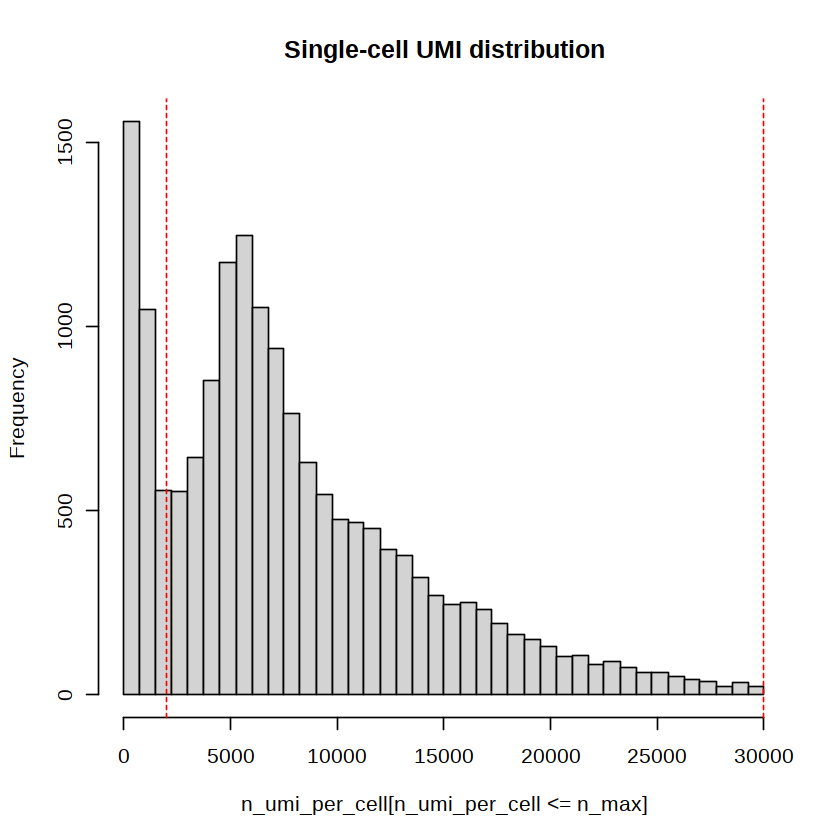

In [16]:
n_umi_per_cell = colSums(mat@mat)
n_min = 2000
n_max = 30000
hist(n_umi_per_cell[n_umi_per_cell <= n_max],breaks = seq(0,n_max,length.out = 41), main = "Single-cell UMI distribution")
abline(v = n_min,col = "red",lty = "dashed")
abline(v = n_max,col = "red",lty = "dashed")
message(paste0(sum(n_umi_per_cell < n_min), " cells with <",n_min," UMIs"))
message(paste0(sum(n_umi_per_cell > n_max), " cells with >",n_max," UMIs"))

In [17]:
small_cells = colnames(mat@mat)[n_umi_per_cell < n_min]
large_cells = colnames(mat@mat)[n_umi_per_cell > n_max]

cells_ignore = unique(c(small_cells,large_cells,cells_with_high_mito_content))
message(paste0(length(cells_ignore), " cells will be ignored"))

3401 cells will be ignored



In [18]:
mat = scm_ignore_cells(scmat = mat,ig_cells = cells_ignore)

In [21]:
scdb_add_mat(id = "exutero",mat = mat)